# Assignment 2

**Assignment 2: Sampling**

**Goal**: ​​Get familiar with sampling methods by implementing these methods and applying them to a given probability distribution.

In this assignment we are going to learn about sampling methods. The goal is to implement *Metropolis-Hastings** (MH) algorithm and **Simulated Annealing** (SA) algorithm and analyze their behavior. Importantly, we aim at noticing differences between these two methods.

Here, we are interested in ​**sampling**​ from a mixture of two Gaussians, namely:

$$
p(\mathbf{x}) = 0.25\cdot \mathcal{N}\left(\mu = \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right) + 0.75\cdot \mathcal{N}\left(\mu = \begin{bmatrix} -3 \\ -3 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

In this assignemnt, you are asked to implement:
1. The Metropolis-Hastings (MH) algorithm.
2. The simulated annealing (SA) algorithm.

After implementing both methods, please run experiments and compare both methods. Please follow all instructions.

## 1. Understanding the probability distribution

Please run the code below and visualize the probability distribution. Please try to understand this distribution, what the modes are (you can do it by inspecting the plot). What are possible problems here?

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

EPS = 1.e-7

In [2]:
mv1 = multivariate_normal(mean=[2.,2.], cov=[[1., 0.5],[0.5, 1.]])
mv2 = multivariate_normal(mean=[-3.,-3.], cov=[[1., 0.],[0., 1.]])

def prob(x):
    return 0.25 * mv1.pdf(x) + 0.75 * mv2.pdf(x)

In [3]:
def calculate_p(x1, x2):
    p_x = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            p_x.append(prob(np.asarray([[x1[i], x2[j]]])))
    
    return np.asarray(p_x).reshape(len(x1), len(x2))

In [4]:
x1 = np.linspace(-10., 10., 400)
x2 = np.linspace(-10., 10., 400)

p_x = calculate_p(x1, x2).reshape(len(x1), len(x2))

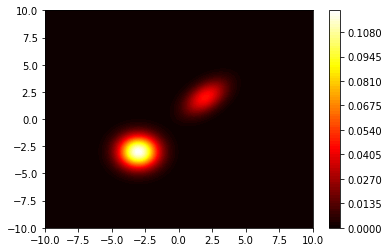

In [5]:
plt.contourf(x1, x2, p_x, 100, cmap='hot')
plt.colorbar()

**Question 1 (0-0.5pt):** How many modes do we have and what are they? What is the most probable point?

**Answer:**
There are two Guassian distributions in this plot, one with mean [-3,-3] which is not skewed and the other with mean [2,2] that is skewed according to the sum-matrix representing the principal components of the distribution. Both distributions are also weighted which means that samples from the "heavier" (former) distribution are more likely and the ones from the lighter (latter) distribution are less likely. The two modes are represented by the brightest points in the two spots.
When sampling from a normal distribution, the means are most likely also going to be representing the modes since they are most often sampled.
From all this, it can be said that the two modes (most frequent values) are to be found at the brightest spots of the two ellipses and the most likely one is the lower left spot since that one originates from the distribution with more weight.

## 2. The Metropolis-Hastings algorithm

First, you are asked to implement the Metropolis-Hastings (MH) algorithm. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

NOTE: To implement the MH algorithm, you need to specify the proposal distribution.

**Question 2 (0-0.5pt):** What is the proposal distribution, $q(\mathbf{x}_{new} | \mathbf{x}_{old})$, in your case?

**Answer:**
To keep things easy, a normal distribution was used. This means that $\mu = x_{old}$, so the distribution is centered around the currently considered point. The distribution is therefore just the normal distribution given by
$q(\mathbf{x}_{new} | \mathbf{x}_{old}) = \frac{1}{\sigma\sqrt{2\pi}}*e^{-\frac{1}{2}(\frac{x_{new}-x_{old}}{\sigma})^2}$. 

This distribution is symmetric, thus $q(\mathbf{x}_{new} | \mathbf{x}_{old})=q(\mathbf{x}_{old} | \mathbf{x}_{new})$. This entails that $\frac{q(\mathbf{x}_{new} | \mathbf{x}_{old})}{q(\mathbf{x}_{old} | \mathbf{x}_{new})}=1$. That is why this part can be neglected in the implementation.

**Question 3 (0-0.5pt):** Is your proposal a proper proposal distribution? (That is, it must fulfill irreducibility and aperiodicity, see Andrieu et al., "An Introduction to MCMC for Machine Learning".)

**Answer:** The Gaussian from which the neighbors are sampled in the implementation has infinite tails in both the positive as well as the negative direction. For this reason, there exists a (very small) likelihood $\neq0$ for every point to be sampled. It is therefore irreducible.

The Gaussian distribution ensures that samples are taken randomly around the current point. This entails that there cannot be a cyclic movement of the algorithm since it is unknown if or when it returns to the same point. Further, even if the algorithm would return to the same location, the next sample will with very high chance not be the same sample that was drawn previously starting from this point. It is aperiodic, because it never gets stuck in a cycle.

In [6]:
class MetropolisHastings(object):
    def __init__(self, x, prob, std=0.1):
        # initialize the internal values for the algorithm
        self.prob = prob
        self.std = std
        self.x_old = x

    def proposal(self, x):
        # take a two-dimensional sample from a Gaussian distribution with mean as the 
        # current x and the provided standard deviation
        x_new = np.asarray(np.random.normal(x,self.std))
        return x_new

    def evaluate(self, x_new, x_old):
        # since we're working with a symmetrical distribution (Gaussian), we can neglect 
        # the second part of the formula. It always equals one anyways.
        # A is equal to the likelihood over the last likelihood since we want to find 
        # neighbors that are more likely than the current
        A = self.prob(x_new)/self.prob(x_old)
        return np.minimum(1., A)
  
    def select(self, x_new, A):
        # with a random chance, neighbors will be accepted that have a lower probability 
        # than the current one, this is ensured using the random uniform sample 
        # between 0 and 1
        if A > np.random.uniform():
            self.x_old = x_new
        return self.x_old
  
    def step(self):
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

In [7]:
def plot_sampling_process(ax, sampler, title):
    # Plot the objective function
    ax.contourf(x1, x2, p_x/p_x.sum(), 100, cmap='hot')

    # Init the solution
    x_samp = sampler.x_old
    # Run the optimization algorithm
    count = 0 # we calculate how many of new candidates were accepted
    for i in range(num_epochs):
        x = sampler.step()

        if (x == x_samp[-1]).all():
            pass
        else:
            count = count + 1
            x_samp = np.concatenate((x_samp, x),0)

    ax.scatter(x_samp[:,0], x_samp[:,1], marker='+')
    ax.set_xlim([-10,10])
    ax.set_ylim([-10,10])
    # We add AR (Acceptance Rate) to the title.
    ax.set_title(title + ' AR={:.2f}'.format(count/num_epochs))

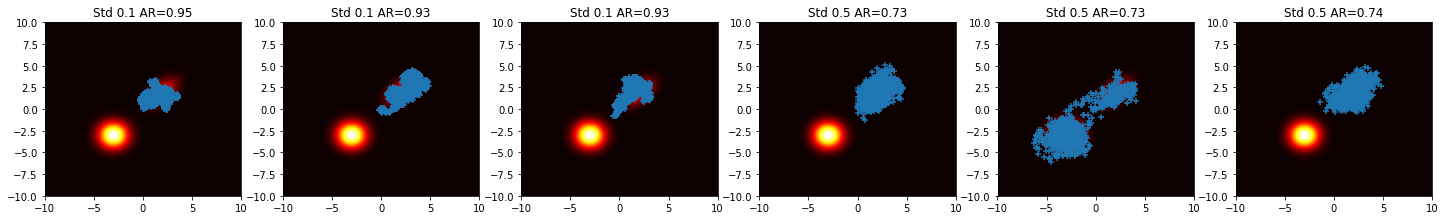

In [8]:
# PLEASE DO NOT REMOVE!
# Running the MH algorithm with different step sizes
num_epochs = 1500 # the number of epochs
stds = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5] # we repeat experiments 3 times per std

# plotting the convergence of the MH
fig_mh, axs = plt.subplots(1,len(stds),figsize=(20, 3))
fig_mh.tight_layout()

x_init = np.asarray([[0., 0.]])

for i in range(len(stds)):
  # take the std
  std = stds[i]
  # init the MH
  mh = MetropolisHastings(x=x_init, prob=prob, std=std)
  # plot the convergence
  plot_sampling_process(axs[i], sampler=mh, title='Std ' + str(mh.std))

**Question 4 (0-0.5)**: Please comment on the behavior of the MH for different values of the standard deviation. Is it always possible to sample from both modes?

**Answer**: The lower standard deviation leads to less exploration since closer candidates are explored. This  means that even after running it several times, mostly only one of the two modes are explored with $std=0.1$ and the algorithm rarely ever "discovers" the other. However, with a higher standard deviation of 0.5, by chance, local minima can be escaped and thus more modes are explored since samples are taken further away from the current position (more exporation).
I also ran the experiment for 10,000 epochs and in that case, even with the smaller $std$, both modes are explored. This, however, still means that sampling occurs from less modes when the standard deviation is lower.

**Question 5 (0-0.5)**: Please comment on the acceptance ratio (AR) for std=0.1 and std=0.5. How can you explain the difference?

**Answer**: A higher standard deviation (of 0.5) makes it less likely that neighbors have a better probability density since they are sampled from further away. This means that they are less likely to be accepted, leading to a lower acceptance rate. In the case of the lower standard deviation (of 0.1), samples are taken from a more close-by neighborhood. This entails that they are closer to the mean and therefore accepted more frequently. Overall, 0.5 leads to an acceptance rate of around 0.73 and 0.1 to one of 0.94, this is a significant difference between the two.

## 3. The simulated annealing (SA) sampling

In the second part of this assignment, you are asked to implement the Simulated Annealing (SA) algorithm with cooling scheme as dicussed during the lecture.

**Question 6 (0-0.5pt)**: Please explain what is the difference between MH and SA?

**Answer**: SA is an algorithm that includes a cooling scheme when sampling from the proposal distribution. With higher temperature, unlikely samples are taken and accepted, i.e. which are outside the proposed distribution (making it almost uniform sampling). This means that initially, SA takes samples outside the distribution which prioritizes exploration over exploitation. Later, as temperature lowers, SA takes samples more and more strongly according to the distribution and therefore prioritizes exploitation because the closer neighborhood is explored.

MH is the simpler variant of the two and samples from an unknown probability distribution. Only the objective function is known, which is some approximation (by some constant) of the unknown distribution that is to be explored. As a result, MH can get stuck in local minima since less occuring neighbors are rarely sampled and steps away from the currently explored mode almost never taken.

**Question 7 (0-0.5pt)**: Why is SA sometimes more preferrable than MH? Which of these two methods would you use for optimization (not sampling)?

**Answer**: As explained in the previous question, due to the initially high temperature of SA, it takes samples from more modes, which enables it to find (or to sample from) more modes overall than MH. There is less of a chance to get stuck in local minima and therefore a better chance to find the global minimum.
Overall, SA likely ultimately converges towards an optimal solution while MH can get infinitely stuck in local minima. 

In [15]:
# the standard log of np is to the base E, making it the natural log, 
# I find that confusing and rename it to ln
from numpy import log as ln

class SimulatedAnnealing(object):
    def __init__(self, x, prob, std=0.1, T0=1., C=1.):
        self.prob = prob
        self.std = std
        self.x_old = x
        self.T0 = T0
        self.C = C
        self.t = 0

    def proposal(self, x):
        # taking two random samples in a two-dimensional array from the proposed normal 
        # distribution just like in MH
        x_new = np.asarray(np.random.normal(x,self.std))
        return x_new

    def evaluate(self, x_new, x_old, T):
        # the sample is influenced by the inverse of temperature T at the current step
        A = (self.prob(x_new)/self.prob(x_old))**(1/T)
        return np.minimum(1., A)
  
    def select(self, x_new, A):
        # accepting A according to the uniform draw just like in MH
        if A > np.random.uniform():
            self.x_old = x_new
        return self.x_old

    def step(self):
        # updating the current temperature given constant C and T0 as well as the current 
        # step counter t.
        T = 1/(self.C*ln(self.t+self.T0)+EPS) # the EPS (or epsilon) is added to avoid 
                                              # division by 0 since t is initially 0 
        # update the step counter
        self.t = self.t + 1
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old, T)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

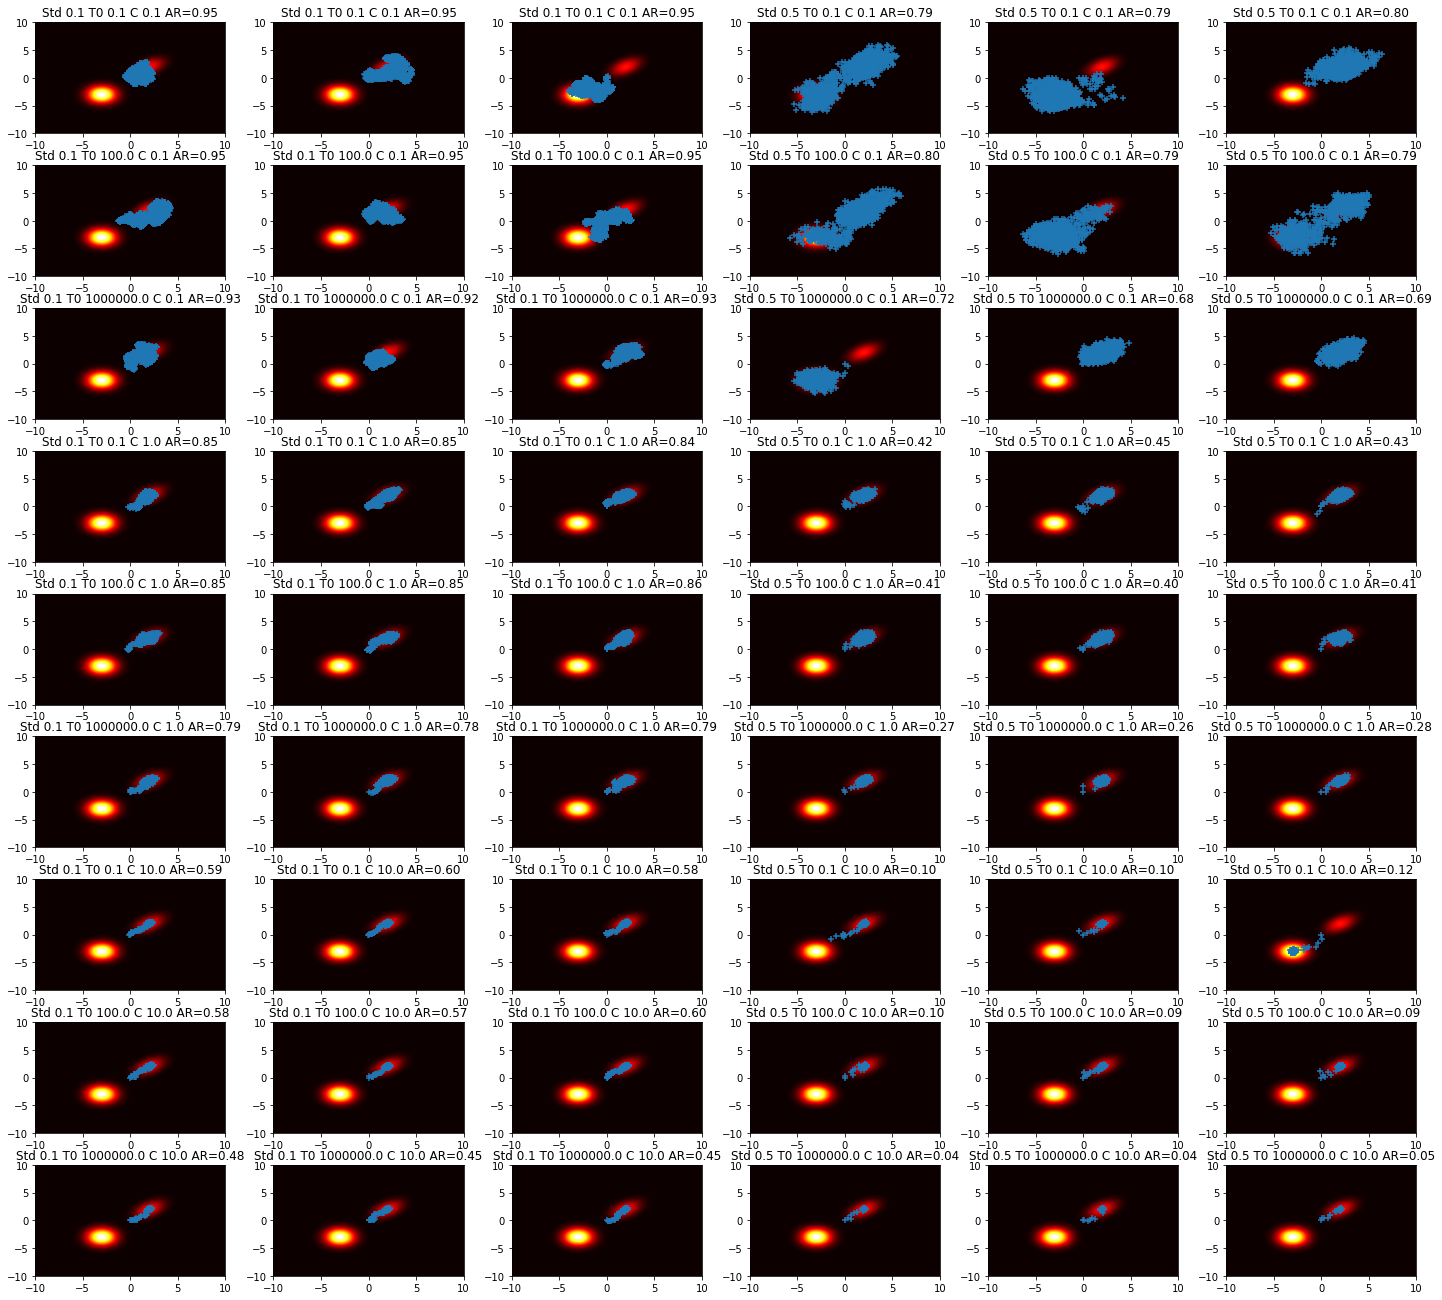

In [20]:
# PLEASE DO NOT REMOVE!
# Running the SA algorithm with different step sizes
num_epochs = 1500 # the number of epochs
stds_sa = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5] # values of std; 
# notice we repeat them due to randomness
T0s = [0.1, 100., 1000000.] # values of T0
Cs = [.1, 1., 10.] # values of C

# plotting the convergence of the MH
fig_sa, axs = plt.subplots(len(Cs) * len(T0s),len(stds_sa),figsize=(20, 18))
fig_sa.tight_layout()

# Always start with the same point
x_init = np.asarray([[0., 0.]])

# START SA
for i in range(len(Cs)):
    # Take a value for C
    C = Cs[i]
    for k in range(len(T0s)):
    # Take a value for the init temperature T0
        T0 = T0s[k]
        for j in range(len(stds_sa)):
            # take the std
            std = stds_sa[j]
            # init the SA
            sa = SimulatedAnnealing(x=x_init, prob=prob, std=std, T0=T0, C=C)
            # plot the sampling process
            plot_sampling_process(axs[len(T0s)*i+k,j], sampler=sa, \
                title='Std ' + str(sa.std) + ' T0 ' + str(T0) + ' C ' + str(C))

**Question 8 (0-0.5pt)** How does the standard deviation influence the SA?

**Answer:** As also previously stated, a lower standard deviation ($std$) leads to less exploration because of the narrower bell shape of the normal distribution. This prioritizes exploitation (sampling close-by) over exploration, i.e. sampling further away and therfore exploring the search space more. This behavior leads to two results; one being the higher acceptance rate of close sampling (so of the lower $std$) because values are closer to the mode, therefore more similar, thus more often accepted. The other results is that in most cases of lower $std$, only from one of the two modes, samples are taken - which means that this algorithm can get more easily stuck in local minima. The higher $std$ leads to opposing results: the modes are less closely explored (exploitation) and samples taken from further distant points in the search space. Whereas $std=0.1$ does not have a single instance where it sampled from both modes, $std=0.5$ does have a couple runs where both modes are sampled from. Overall, higher $std$ means that more of the search space is explored and thus, the likelihood of finding the global optimum is higher.

**Question 9 (0-0.5pt)** How does the initial temperature, $T_0$, influence the SA?

**Answer:** The function of Time T given the current step count t in this particular implementation is given by $T(t)=\frac{1}{C \ln{(t+t_0)+\epsilon}}$. The summand $\epsilon$ was added to the denominator in order to avoid division by 0. 

$T(t)$ normalizes the acceptance probability function $A$ using its inverse: $$A(t)\rightarrow A^{\frac{1}{T(t)}} = A^{\frac{1}{\frac{1}{C \ln{(t+t_0)+\epsilon}}}}=A^{C \ln{(t+t_0)+\epsilon}}$$

Now, this can be taken as a new function $B$ of the acceptance likelihood: $B(t,a)=a^{C \ln(t+t0)+\epsilon}$, where $a$ are the probability densities of the samples and $t$ the step in time. This function was plotted in the following image with $t=1$.

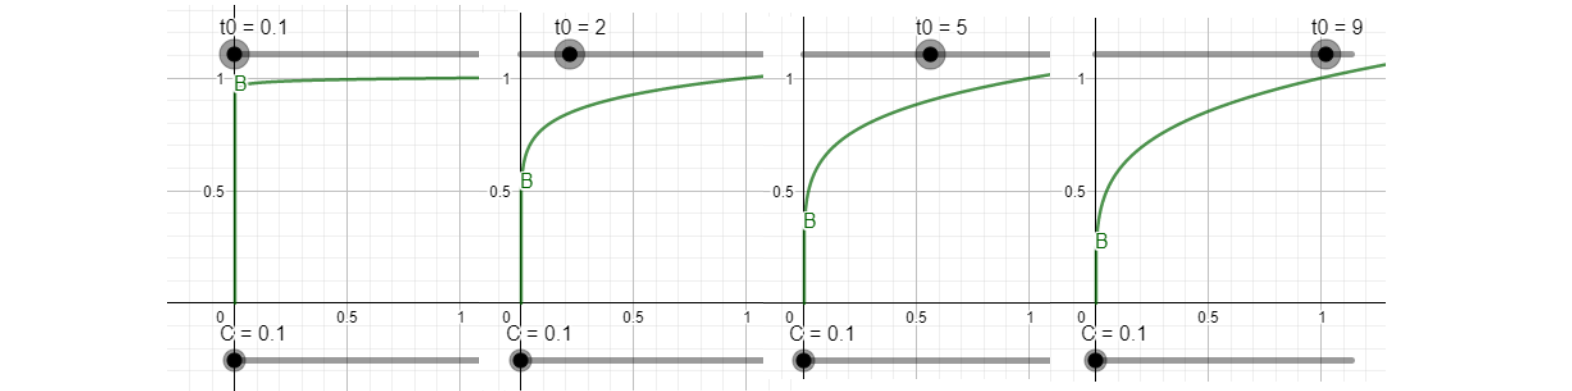

The lower an exponent of a floating point number between $0$ and $1$, the higher its outcome. Further, the natural logarithm is a function of monotonic growth, so higher input values yield higher output. Reasoning from these two statements, higher $t_0$ lead to higher exponents in B which lead to lower function values.

The plots show this clearly. A lower $t_0$ (slider at the top of the graphs) makes for a higher temperature. This means, that samples with low probability density (density being represented by the $x$-axis), are accepted with a higher likelihood (acceptance likelihood represented by $y$-axis). Consequentially, a higher $t_0$ (i.e. starting temperature) makes for more a lower overall temperature during sampling, which leads to a lower acceptance rate. Evidence for this are the SA plots above where higher starting temperature leads to a lower acceptance rate at step $t=1$.

**Question 10 (0-0.5pt)** How does the constant $C$ influence the SA?

**Answer:** The reasoning about the impact of the temperature constant $C$ is very similar to the one described above since it is part of the same equation and, similarly to $t_0$, scales the exponent of $B(t,a)=a^{C \ln(t+t_0)+\epsilon}$. The following plots show how varying $C$ influences the shape of $B$, which represents the impact of the temperature $T$ on the acceptance probability $a$.

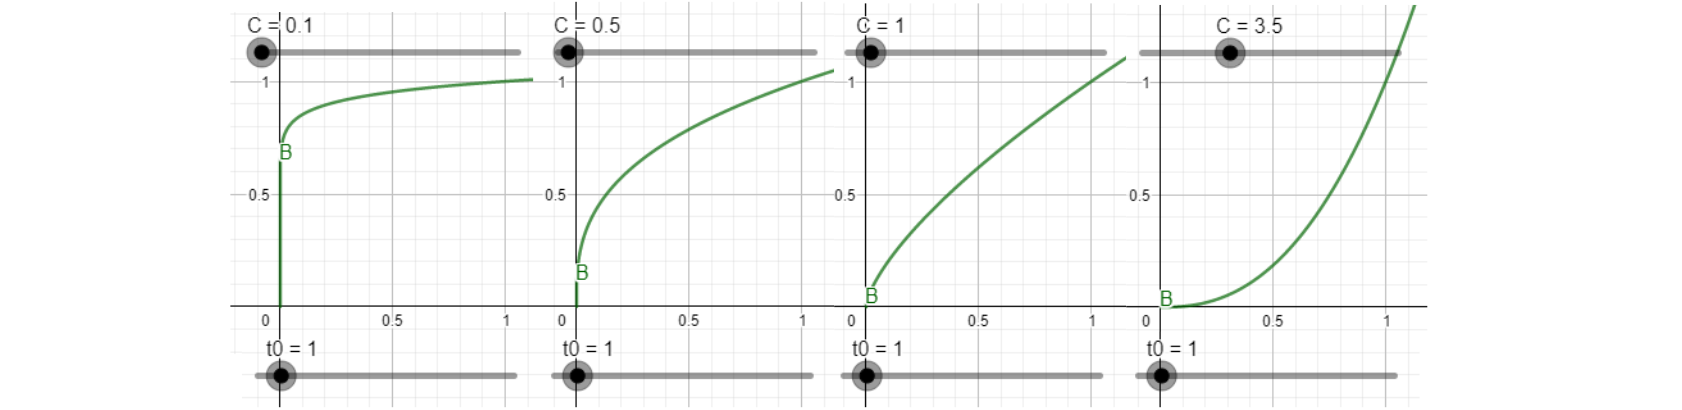

Unsuprisingly, the results are the same as above. The lower an exponent of a floating point number between $0$ and $1$, the higher its outcome. Since constant $C$ scales the exponent, a lower $C$ leads to a lower exponent in function $B$. This entails a higher function value ($y$-axis) for the same input ($x$-axis). 

A higher temperature (for example in the left most plot), which for a low number of steps $t$ leads to an almost uniform acceptance of samples. This means that no matter how low their probability density is, they are still being accepted as samples because of $T$'s impact on them. Evidence for this are the SA plots above where higher constant leads to a lower acceptance rate.

**Question 11 (0-0.5pt)** Which setting (i.e., std, $T_0$, $C$) did perform the best in terms of sampling?

**Answer:** In order to see more visually appealing results, I scaled the provided hyperparameters a bit.


The sampling can be judged based on to different observations. Since every sampling takes place three times with the same hyperparameters, one could say that overall consistent results are the most important measure to rank the results. On the other hand, it might be interesting to only look at one of the three iterations at a time.

Given the plots of my implementation, $std=0.5$ $t_0=100$, $C=0.1$ deliveres the past results in my opinion. All three plots show that instances from both modes are sampled and the results look relatively consistent. As stated, higher $t_0$ and $C$ values lower the overall temperature, making exploration almost impossible. That is why the lower two thirds of the results show batches where exploitation was overprioritized.

**Question 12 (0-0.5pt)** How do different values of the hyperparameters (i.e., std, $T_0$, $C$) influence the acceptance ratio (AR)? Why?

**Answer:** I already answered this question in the previous three answers, therefore I will here only give a brief summary of what I said above:

1. A lower standard deviation ($std$) $\rightarrow$ less exploration because of the narrower bell shape of the normal distribution $\rightarrow$ a higher acceptance rate due to close sampling (so of the lower $std$) since probability densities are closer to the mode $\rightarrow$ new samples more similar to current $\rightarrow$ more often accepted $\Rightarrow$ $std$ negatively correlates with acceptance rate.
2. A lower $t_0$ makes for a higher temperature $\rightarrow$ samples with low probability density, are accepted with a higher likelihood $\rightarrow$ a higher $t_0$ (i.e. starting temperature) makes for more a lower overall temperature during sampling $\rightarrow$ lower acceptance rate $\Rightarrow$ $t_0$ negatively correlates with acceptance rate.
3. A lower constant $C$ $\rightarrow$ a higher overall temperature, which for a low number of steps $t$ $\rightarrow$ almost uniform sampling $\rightarrow$ no matter how low the probability density, samples are still being accepted because of $T$'s impact on them. $\rightarrow$ higher acceptance rate $\Rightarrow$ $C$ negatively correlates with acceptance rate.

## 4. Final remarks: MH vs. SA

Eventually, please answer the following last questions that will allow you to conclude the assignment and draw conclusions.

**Question 13 (0-0.5-1pt)**: Which of the two algorithms did perform better? Why?

**Answer**: MH is less computationally expensive due to less steps when taking one sample. In most cases, and even with a higher $std$ of $0.5$, only one of the modes was explored. 

SA was more expensive to compute but on the other hand, with the right fine-tuning of hyperparameters, an optimal solution was more likely found with this implementation due to its initial focus on exploration. Overall, with the right optimization (see e.g. plots of $std=0.5$ $t_0=100$, $C=0.1$), SA was more successful in sampling from both modes in the search space.

**Question 14 (0-0.5-1pt)**: Which of the two algorithms is easier to use? Why?

**Answer**: Using the normal distribution in the MH algorithm made it relatively easy to understand and implement because of the symmetry of the bell curve. It used very little hyperparameters and as a result will need less manual adjusting. SA was much more complex to implement due to the impact that temperature has over time on the sampling. This led to an abundance of hyperparameter with their own impact on the exploration-versus-exploitation problem. In this easy case with two modes, MH was more applicable due to its simplicity. However, in the industry, search spaces can have many more dimensions and modes, which is why in those applications, it makes sense to apply the more complex SA algorithm.